This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Load and inspect data from a Rainbow file

In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

#### Load Rainbow file

In [2]:
filename = wrl.util.get_wradlib_data_file("rainbow/2013070308340000dBuZ.azi")
rbdict = wrl.io.read_rainbow(filename)

#### Get azimuthal data

In [3]:
azi = rbdict["volume"]["scan"]["slice"]["slicedata"]["rayinfo"]["data"]
azidepth = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rayinfo"]["@depth"])
azirange = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rayinfo"]["@rays"])
azires = float(rbdict["volume"]["scan"]["slice"]["anglestep"])
azi = (azi * azirange / 2**azidepth) * azires

#### Create range array

In [4]:
stoprange = float(rbdict["volume"]["scan"]["slice"]["stoprange"])
rangestep = float(rbdict["volume"]["scan"]["slice"]["rangestep"])
r = np.arange(0, stoprange, rangestep)

#### Get reflectivity data

In [5]:
data = rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["data"]
datadepth = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["@depth"])
datamin = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["@min"])
datamax = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["@max"])
data = datamin + data * (datamax - datamin) / 2**datadepth

#### Get annotation data

In [6]:
unit = rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["@type"]
time = rbdict["volume"]["scan"]["slice"]["slicedata"]["@time"]
date = rbdict["volume"]["scan"]["slice"]["slicedata"]["@date"]
lon = rbdict["volume"]["sensorinfo"]["lon"]
lat = rbdict["volume"]["sensorinfo"]["lat"]
sensortype = rbdict["volume"]["sensorinfo"]["@type"]
sensorname = rbdict["volume"]["sensorinfo"]["@name"]

#### Convert to DataArray

In [7]:
da = wrl.georef.create_xarray_dataarray(data, r=r, az=azi).wrl.georef.georeference()

#### Plot data with annotation

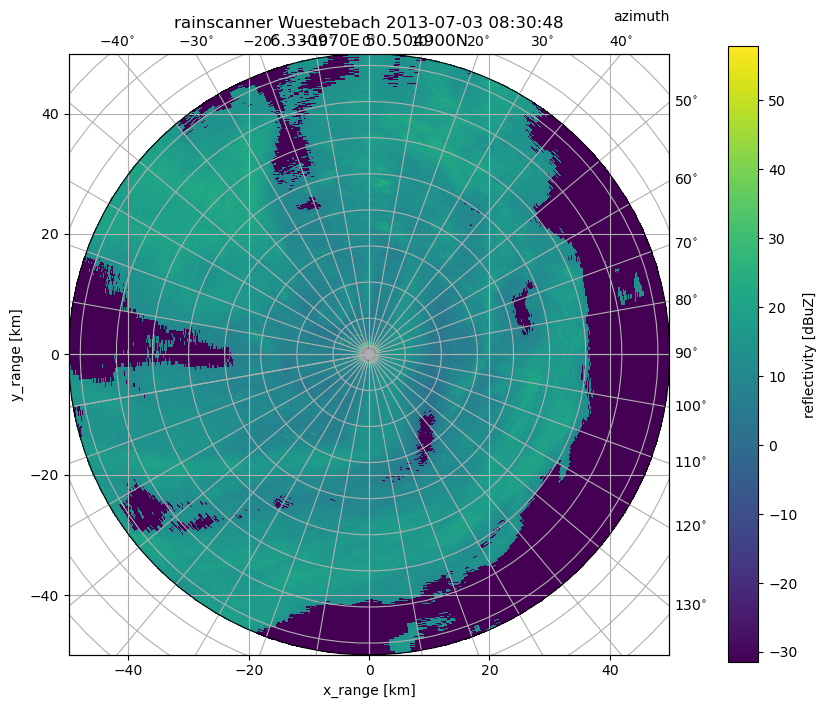

In [8]:
fig = plt.figure(figsize=(10, 8))
pm = da.wrl.vis.plot(fig=fig, crs="cg")

cgax = plt.gca()
title = "{0} {1} {2} {3}\n{4}E {5}N".format(
    sensortype, sensorname, date, time, lon, lat
)
caax = cgax.parasites[0]
paax = cgax.parasites[1]


t = plt.title(title, fontsize=12)
t.set_y(1.1)
cbar = plt.colorbar(pm, ax=[cgax, caax, paax], pad=0.075)
caax.set_xlabel("x_range [km]")
caax.set_ylabel("y_range [km]")
plt.text(1.0, 1.05, "azimuth", transform=caax.transAxes, va="bottom", ha="right")
cbar.set_label("reflectivity [" + unit + "]")